# Forecast Evaluations

### Classic Train/Test Split

In [1]:
import pandas as pd
from prophet import Prophet
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('Miles_Traveled.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [4]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [5]:
df.columns = ['ds','y']

In [6]:
# YOU CAN SAFELY IGNORE THIS COPY WARNING
# CHECK THE DOCS LINK FOR MORE INFO ON THIS COPY WARNING
df['ds'] = pd.to_datetime(df['ds'])

In [7]:
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


<AxesSubplot:xlabel='ds'>

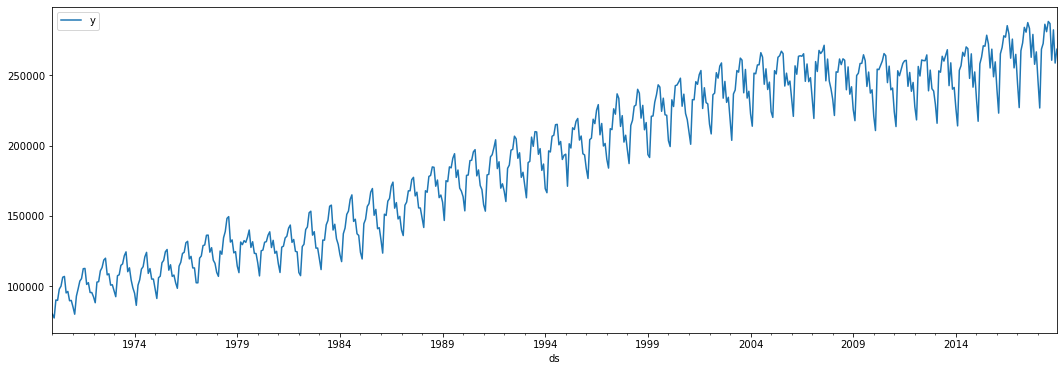

In [8]:
df.plot(x='ds',y='y',figsize=(18,6))

In [9]:
len(df)

588

In [10]:
len(df) - 12

576

In [11]:
train = df.iloc[:576]
test = df.iloc[576:]

In [12]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263245.058351,273746.195875,285297.027866,263166.198567,263325.650510,16449.460061,16449.460061,16449.460061,16449.460061,16449.460061,16449.460061,0.0,0.0,0.0,279694.518411
584,2018-09-01,263383.617824,255921.068564,267384.073160,263277.481397,263490.310758,-1667.814849,-1667.814849,-1667.814849,-1667.814849,-1667.814849,-1667.814849,0.0,0.0,0.0,261715.802975
585,2018-10-01,263517.707638,263110.307214,274489.628591,263382.945376,263655.523842,5308.660275,5308.660275,5308.660275,5308.660275,5308.660275,5308.660275,0.0,0.0,0.0,268826.367913
586,2018-11-01,263656.267111,249364.200388,261248.908198,263486.174646,263820.704434,-8205.574125,-8205.574125,-8205.574125,-8205.574125,-8205.574125,-8205.574125,0.0,0.0,0.0,255450.692986
587,2018-12-01,263790.356925,251364.544903,262746.432886,263570.418156,263996.385645,-6918.925391,-6918.925391,-6918.925391,-6918.925391,-6918.925391,-6918.925391,0.0,0.0,0.0,256871.431533


In [14]:
test.tail()

,ds,y
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0
586,2018-11-01,258590.0
587,2018-12-01,268413.0


[Info on ax= parameter](https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure)

<AxesSubplot:xlabel='ds'>

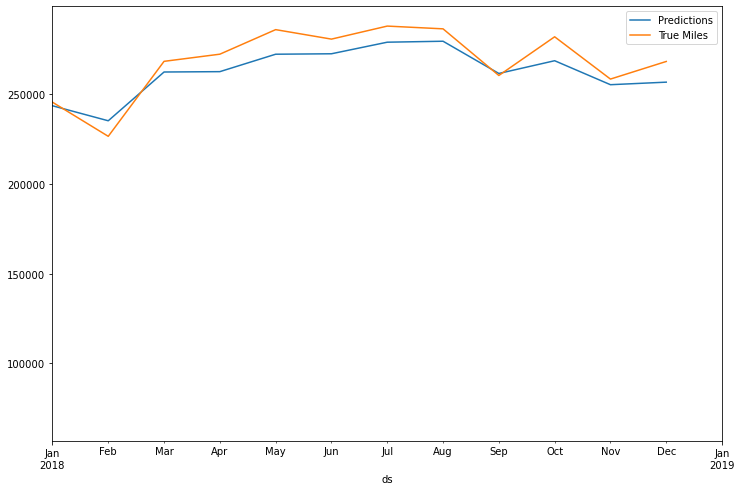

In [15]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2018-01-01','2019-01-01'))

In [16]:
from statsmodels.tools.eval_measures import rmse

In [17]:
predictions = forecast.iloc[-12:]['yhat']

In [18]:
predictions

576    243705.449748
577    235333.183587
578    262533.190754
579    262731.852786
580    272452.943289
581    272703.387235
582    279160.141162
583    279694.518411
584    261715.802975
585    268826.367913
586    255450.692986
587    256871.431533
Name: yhat, dtype: float64

In [19]:
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [20]:
rmse(predictions,test['y'])

8733.457468164821

In [21]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train)
future = m.make_future_dataframe(periods=12,freq='MS')
forecast = m.predict(future)
predictions = forecast.iloc[-12:]['yhat']
rmse(predictions,test['y'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7111.945720463335

### You don’t see AIC or BIC for Prophet because it is a Bayesian model, while AIC and BIC are about the likelihood. For Bayesian model you would rather use WAIC or DIC, or cross-validation.

# Prophet Diagnostics / CROSSVALIDATION - OPCIONAL

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

In [22]:
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric

In [23]:
len(df)

588

The initial period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

In [26]:
# help(pd.Timedelta)

In [43]:
# Initial 5 years training period
initial = 5* 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [44]:
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)

INFO:prophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

In [42]:
df_cv.head(50)
# primer fld hasta 1976 y luego 1977 de horizon (de test)
# segundo fold hasta 1981 (1976+5 años) y se valida en 1982
# tercer fold hasta 1986 (1976+5+5 años) y se valida en 1987

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,106264.483188,104916.012590,107710.011419,102445.0,1976-12-11
1,1977-02-01,99635.331799,98207.107107,101132.712040,102416.0,1976-12-11
2,1977-03-01,118429.888369,117040.705337,119734.726827,119960.0,1976-12-11
3,1977-04-01,120350.669586,119016.273002,121728.547678,121513.0,1976-12-11
4,1977-05-01,128575.446825,127097.680765,129915.524072,128884.0,1976-12-11
5,1977-06-01,130495.043981,129015.984267,131920.093656,129321.0,1976-12-11
6,1977-07-01,137776.896578,136164.309481,139259.345787,136199.0,1976-12-11
7,1977-08-01,139781.437501,138088.148748,141327.120172,136337.0,1976-12-11
8,1977-09-01,125213.414479,123400.371680,126862.596637,124203.0,1976-12-11
9,1977-10-01,127591.092017,125703.619575,129255.630601,127388.0,1976-12-11


In [214]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
103,2017-08-01,273254.523501,267202.320371,279511.599691,283184.0,2016-12-01
104,2017-09-01,255372.720203,249330.743827,261084.844672,262673.0,2016-12-01
105,2017-10-01,262476.518564,256769.520993,268001.419001,278937.0,2016-12-01
106,2017-11-01,249126.648938,243459.338900,254747.159187,257712.0,2016-12-01
107,2017-12-01,250371.688410,244625.193390,256090.260107,266535.0,2016-12-01


### The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates. 

SOlo da horizon para los que tienen ese valor en todos los folds

In [215]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
1,52 days,2.484109e+07,4984.083210,4590.014835,0.028137,0.3
13,53 days,2.226842e+07,4718.943023,4318.899977,0.025335,0.3
25,54 days,1.882583e+07,4338.874820,3803.991852,0.020509,0.4
37,55 days,2.374039e+07,4872.411127,4319.472747,0.023528,0.3
49,57 days,2.150039e+07,4636.851520,4050.449106,0.021775,0.4
61,58 days,2.377014e+07,4875.463292,4327.071181,0.022979,0.3
73,59 days,3.857268e+07,6210.691064,5144.794773,0.026666,0.3
85,60 days,3.959640e+07,6292.566974,5229.654576,0.027225,0.3
97,62 days,3.773627e+07,6142.985167,4985.238970,0.026153,0.4
2,80 days,3.264865e+07,5713.899872,4364.416238,0.024037,0.5


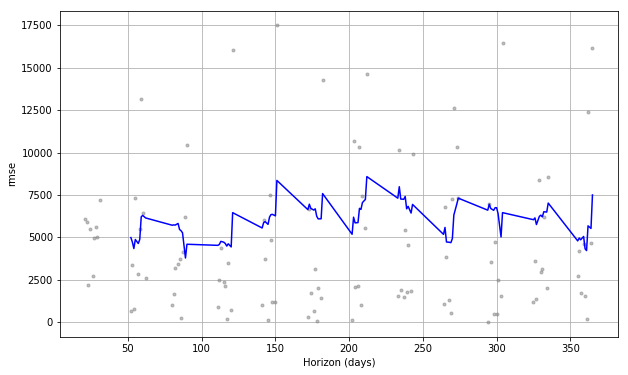

In [217]:
plot_cross_validation_metric(df_cv, metric='rmse');

MAPE is Mean Absolute Percentage Error

https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

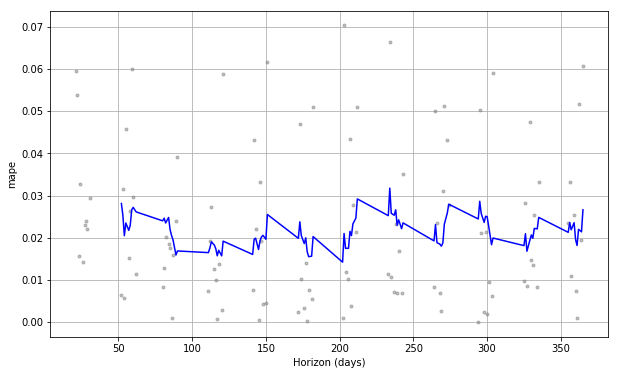

In [218]:
plot_cross_validation_metric(df_cv, metric='mape');